# What is TORCH.NN REALLY?

PyTorch provides the elegantly designed modules and classes torch.nn , torch.optim , Dataset , and DataLoader to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they’re doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from torch.nn, torch.optim, Dataset, or DataLoader at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

# MNIST data setup

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

Each image is 28 x 28 and is being stored as a flattened row of length 784(=28x28). Let's take a look at one; we need to reshape it to 2d first.

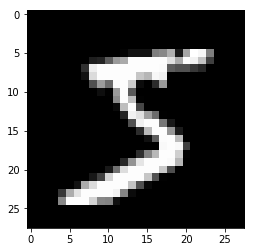

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')

PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.

In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

In [16]:
import math 
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [20]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [21]:
bs = 64 # batch size
xb = x_train[0: bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.0079, -2.6148, -2.4300, -2.7246, -1.9979, -1.9304, -2.5073, -2.1990,
        -2.9581, -2.1725], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.



In [28]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [30]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3264, grad_fn=<NegBackward>)


In [31]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [33]:
print(accuracy(preds, yb))

tensor(0.1406)


In [38]:
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2 # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [39]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0832, grad_fn=<NegBackward>) tensor(1.)


# Using torch.nn.functional

In [41]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [42]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0832, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module

Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

In [44]:
from torch import nn


class Mnist_Logistic(nn.Module): # nn.Module(uppercase M) 
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias
        

In [46]:
model = Mnist_Logistic()

In [49]:
print(loss_func(model(xb), yb))

tensor(2.3209, grad_fn=<NllLossBackward>)


In [56]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()

In [57]:
print(loss_func(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

In [58]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.lin(xb)

In [59]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3832, grad_fn=<NllLossBackward>)


In [61]:
fit()

In [62]:
print(loss_func(model(xb), yb))

tensor(0.0821, grad_fn=<NllLossBackward>)


## Refactor using optim

In [67]:
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
    model.zero_grad()

### instead use just
- opt.step()

- opt.zero_grad()

(optim.zero_grad() resets the gradients to 0 and we need to call it before computing the gradient for the next minibatch.)

In [69]:
from torch import optim

In [83]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(2.2655, grad_fn=<NllLossBackward>)
tensor(0.0824, grad_fn=<NllLossBackward>)


# Refactor using Dataset

In [84]:
from torch.utils.data import TensorDataset

In [85]:
train_ds = TensorDataset(x_train, y_train)

In [103]:
"""
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
"""
# we can do these two steps together.
xb, yb = train_ds[i * bs : i * bs + bs]

In [115]:
get_model()

(Mnist_Logistic(
   (lin): Linear(in_features=784, out_features=10, bias=True)
 ), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.5
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [120]:
model, opt = get_model()
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


# Refactor using DataLoader

In [121]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [126]:
for xb, yb in train_dl:
    pred = model(xb)

In [129]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward>)


## Add validation

In [131]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
# 검증용은 shuffle ㄴㄴ
valid_dl = DataLoader(valid_ds, batch_size = bs * 2)

In [132]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3138)
1 tensor(0.3983)


## Create fit() and get_data() 

In [134]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [135]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

In [138]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [139]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.30796377382278445
1 0.29254882121086123


## Switch to CNN

In [146]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1
        

In [147]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.35934217524528506
1 0.2777922561168671


In [143]:
xb.view(-1, 1, 28, 28).shape

torch.Size([16, 1, 28, 28])

## nn.Sequential

In [149]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)


In [151]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)
    

0 0.3174636568546295
1 0.2561963149547577


## Wrapping DataLoader
Our CNN is fairly concise, but it only works with MNIST, because:
- It assumes the input is a 28*28 long vector
- It assumes that the final CNN grid size is 4*4 (since that’s the average pooling kernel size we used)


Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:

In [174]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)


In [175]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x:  x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [176]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3277725677013397
1 0.2293032516479492
